# Rede Neural Artificial - Multilayer Perceptron

Primeiramente, carregamos as bibliotecas necessárias

In [13]:
from numpy import exp, random, dot, array_equal, round_
from carregar_dados import carregar_dados, preparar_iris, plotar_iris
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style("darkgrid")

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['lines.markersize'] = 50

## Definição das camadas

In [14]:
class Layer:
    """
    Uma camada da rede neural. É criada dessa forma:
    camada = Layer(x, y)
    Onde x é o número de entradas (inputs), e y o número de neurônios (neurons) na camada.
    
    self.w:      Os pesos da camada.
    self.output: O valor de saída dos neurônios.
    self.delta:  A variação de cada neurônios de acordo com a saída esperada.
                 Utilizado durante o processo de backpropagation.
    """
    def __init__(self, inputs, neurons):
        self.w = 2*random.random((inputs, neurons)) - 1
        self.output = []
        self.delta = []
        
    def adjust(self, x, learning_rate):
        """
        Ajusta os pesos da camada de acordo com a taxa de aprendizado (learning_rate).
        O x utilizado refere-se à saída da camada que vem antes desta (da esquerda para direita).
        A multiplicação matricial entre o delta desta camada com o x nos dá o ajuste dos pesos.
        Esse ajuste é somado aos pessos atuais, completanto o processo de backprop.
        """
        self.w += dot(x.T, self.delta) * learning_rate
    
    def calc_delta(self, change, derivative):
        """
        Calcula o delta da camada.
        Esse delta representa a variação de cada neurônio em relação a saída desejada.
        """
        self.delta = change * derivative(self.output)
        return self.delta
    
    def feed(self, x, activation):
        """
        Realiza o processo de feedforward para esta camada.
        Ou seja, pega as entradas da camada e multiplica pelos pesos.
        """
        self.output = activation(dot(x, self.w))
        return self.output

## Definição da rede neural

In [15]:
class RNA:
    """
    A classe que representa a rede neural.
    
    self.layers:       A lista de camadas da rede. A ordem é sempre da esquerda para direita.
                       Assim, a primeira camada da lista será a que recebe os dados de treinamento.
    self.err_progress: Progresso do erro para que possamos visualizá-lo em um gráfico.
    self.acc_progress: Progresso da precisão.
    """
    def __init__(self):
        random.seed(1) # Mantemos o seed estático para que possamos reproduzir os resultados
        
        self.layers = []
        
        self.err_progress = []
        self.acc_progress = []
        self.output = []
    
    def add_layer(self, inputs, neurons):
        """
        Adiciona uma camada à nossa rede neural.
        Ver classe Layer acima.
        """
        self.layers.append(Layer(inputs, neurons))
    
    def sigmoid(self, x):
        """
        A função de ativação da nossa rede.
        O resultado dessa função sempre estará entre 0 e 1.
        
        x: A saída das camadas.
        """
        return 1.0 / (1.0 + exp(-x))
    
    def sigmoid_derivative(self, x):
        """
        A derivada da função de ativação para calcularmos a taxa de mudança das camadas.
        
        x: A saída das camadas.
        """
        return x * (1.0 - x)
    
    def feedforward(self, train_x):
        """
        Realiza o processo de feedforward.
        Ou seja, passa o dataset train_x pela rede neural, e nos dá o resultado final.
        Esse resultado final vai nos dizer se a rede está correta ou não.
        """
        l = train_x
        for layer in self.layers:
            l = layer.feed(l, self.sigmoid)
        
        return l
    
    def backprop(self, train_x, error, learning_rate):
        """
        O algoritmo de backpropagation.
        Realiza o processo reverso de feedforward, aplicando o erro a cada peso de cada camada.
        
        reversed_layers: Lista de camadas com ordem reversa para esse propósito.
        change: A mudança a ser aplicada na camada. Usada no cálculo do delta.
        next_layer: A próxima camada em ordem reversa.
        """
        reversed_layers = list(reversed(self.layers))
        change = error
        next_layer = None
        for count, layer in enumerate(reversed_layers):
            if count != len(reversed_layers) - 1:
                next_layer = reversed_layers[count + 1]
                delta = layer.calc_delta(change, self.sigmoid_derivative)
                change = dot(delta, layer.w.T)
                layer.adjust(next_layer.output, learning_rate)  
            else:
                delta = layer.calc_delta(change, self.sigmoid_derivative)
                layer.adjust(train_x, learning_rate) 
    
    def train(self, training_x, training_y, learning_rate, iterations):
        """
        Treina a rede neural.
        Primeiro faz o feedforward, e depois o backprop.
        
        No meio do caminho, calculamos os progressos do erro e precisão.
        
        learning_rate: A taxa de aprendizado da rede.
        iterations:    Número de iterações. Uma iteração ocorre após um feedforward e um backprop.
        """
        for iteration in range(iterations):
            
            self.feedforward(training_x)
            
            final_output = self.layers[-1].output
            
            error = (training_y - final_output)
            
            self.err_progress.append((abs(error)).mean())
            self.acc_progress.append(self.__calc_accuracy(training_x, training_y, round_(final_output)))
            
            self.backprop(training_x, error, learning_rate)
        
        self.output = round_(self.feedforward(training_x))
        
        print("Precisão final: {}".format(self.acc_progress[-1]))
        print("Erro final: {}".format(self.err_progress[-1]))
    
    def __calc_accuracy(self, set_x, set_y, predictions):
        """
        Calcula a precisão da rede.
        """
        result = 0
        for count, y in enumerate(set_y):
            if array_equal(y, predictions[count]):
                result += 1
        
        return round_(result/len(set_y), 3)
    
    def test(self, set_x, set_y):
        """
        Realiza o teste da rede. Deve ser usado com novas entradas.
        """
        res = self.feedforward(set_x)
        predictions = round_(res)
        accuracy = self.__calc_accuracy(set_x, set_y, predictions)
        error = abs(set_y - res).mean()
        
        print("Prec. Teste: {}\nErro Teste: {}".format(accuracy, error))
    
    def resumo(self):
        """
        Plota o gráfico de erro e precisão ao longo do treinamento.
        """
        fig, ax = plt.subplots()
    
        error, = ax.plot(self.err_progress, label="Erro")
        acc, = ax.plot(self.acc_progress, label="Precisão")
    
        ax.legend()
        plt.show()
        
    def confusion_matrix(self, train_y):
        """
        Plota a matriz de confusão da nossa Rede Neural.
        """
        results = self.output
        matrix_size = len(results[0])
        confusion_matrix = [[0] * matrix_size for x in range(matrix_size)]

        for count, result in enumerate(results):
            index = list(train_y[count]).index(1)
            confusion_matrix[index] += result

        df = pd.DataFrame(confusion_matrix, index=["Iris-setosa", "Iris-versicolor", "Iris-virginica"], 
               columns=["Iris-setosa", "Iris-versicolor", "Iris-virginica"])
        
        sns.heatmap(df, annot=True)

Carregamos os dados a serem usados. Nesse caso, o set Iris.

In [16]:
raw, dados = carregar_dados()

Vamos imprimir os primeiros 5 dados do nosso dataset

In [17]:
print(dados.head())

   sepal length  sepal width  petal length  petal width  class
0           5.1          3.5           1.4          0.2      0
1           4.9          3.0           1.4          0.2      0
2           4.7          3.2           1.3          0.2      0
3           4.6          3.1           1.5          0.2      0
4           5.0          3.6           1.4          0.2      0


Visualizamos os dados a fim de saber a distribuição das características.
plotar_iris é uma função de conveniência que está no arquivo carregar_dados.py

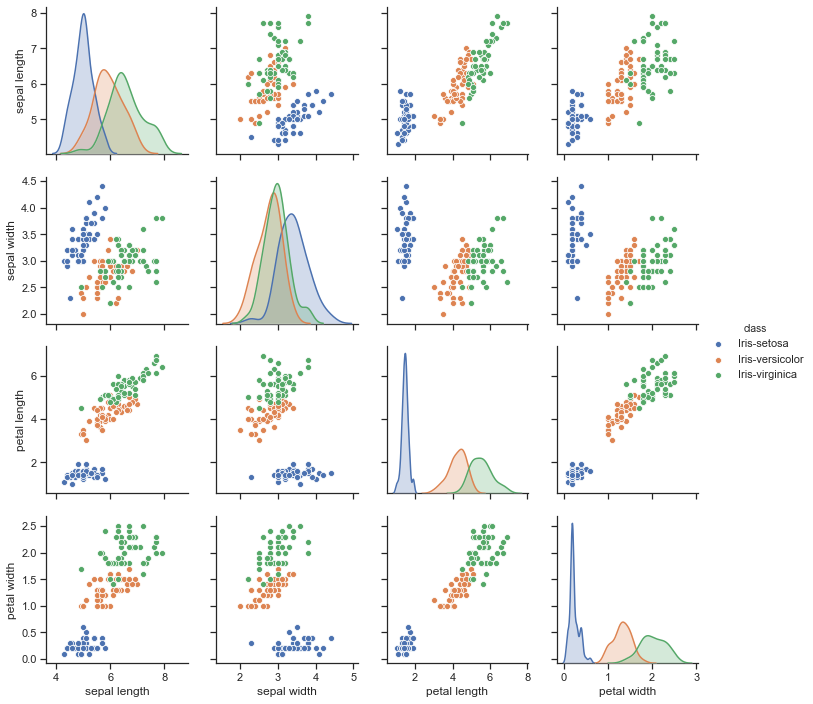

In [18]:
plotar_iris(raw)

Preparamos o nosso dataset para ser utilizado no treinamento da nossa rede. Utilizamos 60% dos dados como dataset de treinamento. O resto será para o teste.

In [19]:
train_x, train_y, test_x, test_y = preparar_iris(dados, 60)

Abaixo, criamos a rede neural e adicionamos 3 camadas.
A primeira com entrada 4 e 3 neurônios, e assim por diante.

In [20]:
rna = RNA()
rna.add_layer(4, 32)
rna.add_layer(32, 64)
rna.add_layer(64, 64)
rna.add_layer(64, 3)

Finalmente, treinamos a nossa rede com os parâmetros a seguir.

In [21]:
rna.train(train_x, train_y, 0.001, 1000)

Precisão final: 0.967
Erro final: 0.1631411124668156


Imprimimos o gráfico de erro e precisão ao longo das iterações.

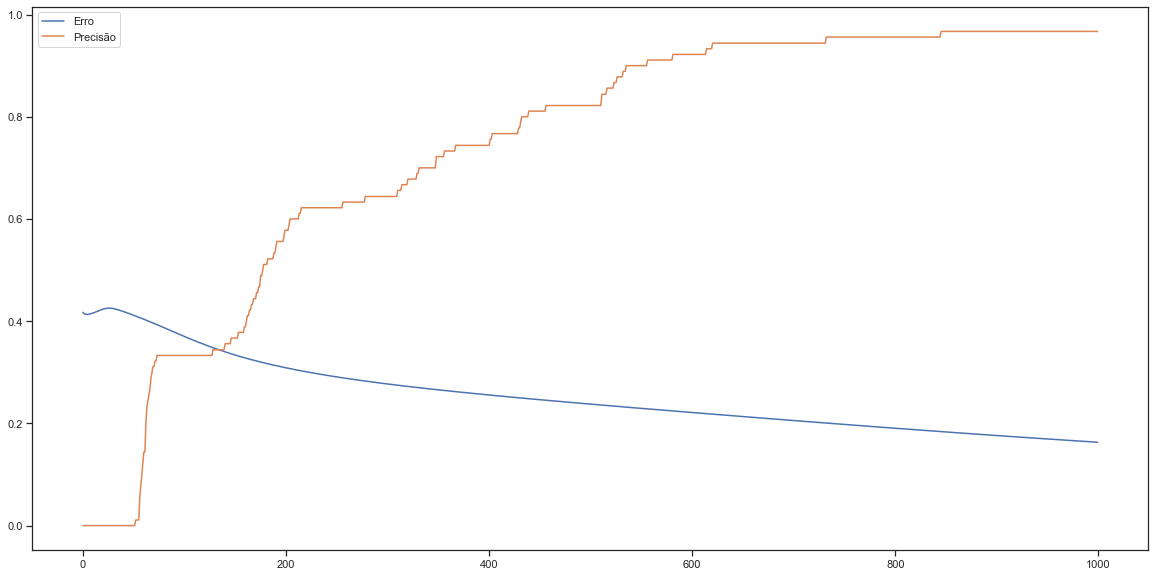

In [22]:
rna.resumo()

Plotamos a matriz de confusão.

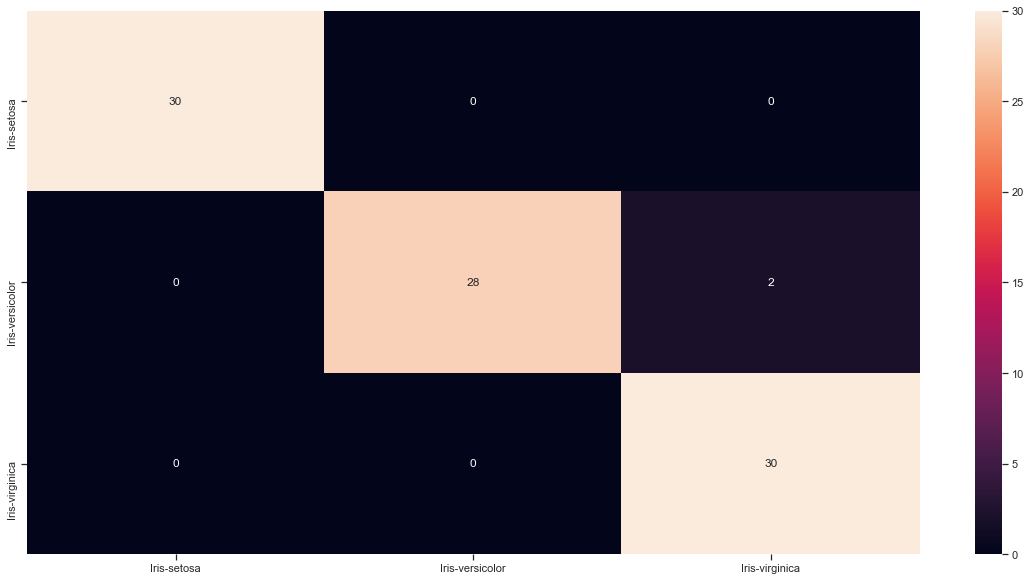

In [23]:
rna.confusion_matrix(train_y)

Agora testamos a rede com novos dados.

In [24]:
rna.test(test_x, test_y)

Prec. Teste: 0.967
Erro Teste: 0.1732814979347221


Caso a precisão esteja muito baixa, pode-se modificar os parâmetros de taxa de aprendizado, número de iterações, e a fração do dataset utilizada para treinamento e a fração de teste. Caso contrário, o treinamento da nossa rede está terminado.